In [1]:
# Import libraries for ML/data cleaning/visualization
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
#Set file path for easy import
import os
os.chdir('/home/jovyan/InterestRatePrediction')
print(os.getcwd())

/home/jovyan/InterestRatePrediction


In [3]:
#Import datasets downloaded from FRED website
#Load Federal Funds Effective Rate, or the'interest rate' to be predicted
ffr = pd.read_csv('DFF.csv')

#Convert date information to datetime type for visualization purposes
ffr['observation_date'] = pd.to_datetime(ffr['observation_date'])
ffr = ffr.set_index('observation_date')
print(ffr.index.dtype)
ffr.head()

datetime64[ns]


,DFF
observation_date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


In [4]:
#Load PCEPI_PC1 dataset from FRED, tracks yearly % changes in inflation, using the Federal Reserve's PCEPI index
#Load unemployment rate data
pcepi, unemp = pd.read_csv('PCEPI_PC1.csv'), pd.read_csv('UNRATE.csv')

#Convert date information to datetime type for visualization purposes
pcepi['observation_date'] = pd.to_datetime(pcepi['observation_date'])
unemp['observation_date'] = pd.to_datetime(unemp['observation_date'])
pcepi = pcepi.set_index('observation_date').rename(columns={"PCEPI_PC1": "PCEPI"})
unemp = unemp.set_index('observation_date')

#Merge three feature variables together into one dataframe for ease of analysis
features = pd.merge(ffr, pcepi, on = 'observation_date', how = 'inner').merge(unemp, on = 'observation_date')
features = features.rename_axis('date', axis = 0)
print(features.index.dtype)
features.head()

datetime64[ns]


,DFF,PCEPI,UNRATE
date,,,
1960-01-01,4.0,1.69480,5.2
1960-02-01,4.0,1.69972,4.8
1960-03-01,4.0,1.69201,5.4
1960-04-01,4.0,1.85952,5.2
1960-05-01,4.0,1.91108,5.1


In [5]:
def lag(num_months):
    features_lagged = features[:len(features) - num_months]
    target = features['DFF'][num_months:].values

    joined = features_lagged.copy()

    column_title = 'DFF (t+' + str(num_months) + ')'
    joined[column_title] = target
    
    return joined

In [6]:
joined = lag(3)
joined.head()

,DFF,PCEPI,UNRATE,DFF (t+3)
date,,,,
1960-01-01,4.0,1.69480,5.2,4.00
1960-02-01,4.0,1.69972,4.8,4.00
1960-03-01,4.0,1.69201,5.4,2.00
1960-04-01,4.0,1.85952,5.2,3.25
1960-05-01,4.0,1.91108,5.1,3.50


## EDA

In [17]:
joined.corr()

,DFF,PCEPI,UNRATE,DFF (t+3)
DFF,1.000000,0.691547,0.068776,0.938863
PCEPI,0.691547,1.000000,0.119230,0.698248
UNRATE,0.068776,0.119230,1.000000,0.042730
DFF (t+3),0.938863,0.698248,0.042730,1.000000


/srv/conda/envs/notebook/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='PCEPI', ylabel='DFF (t+3)'>

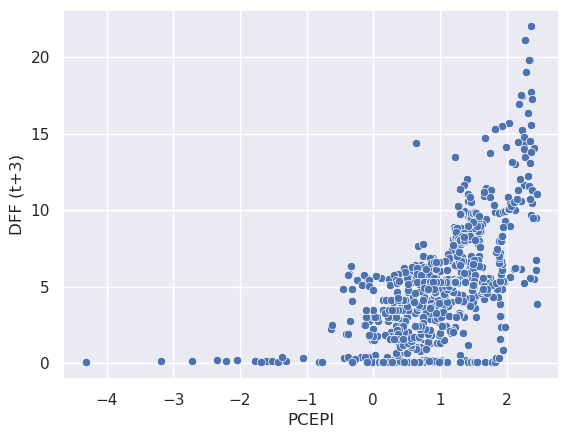

In [23]:
sns.scatterplot(x = np.log(joined['PCEPI']), y = joined['DFF (t+3)'])

## Set up tensors

In [7]:
#Split data into training and testing sets, based on chronological order of data
#For LSTM model, random split cannot be used as it will lead to leakage between train and test sets
train_size = int(0.8 * len(joined))
test_size = len(joined) - train_size
train, test = joined[:train_size], joined[train_size:]

In [8]:
features_to_scale = ['DFF', 'PCEPI', 'UNRATE']

train_scaled = train[features_to_scale].copy()
test_scaled = test[features_to_scale].copy()

for feature in features_to_scale:
    scaler = MinMaxScaler()
    
    # Fit and transform train
    X_train_scaled = scaler.fit_transform(train[[feature]])  # Note [[feature]] keeps it 2D
    train_scaled[feature] = X_train_scaled.flatten()
    
    # Use the same scaler to transform test
    X_test_scaled = scaler.transform(test[[feature]])
    test_scaled[feature] = X_test_scaled.flatten()

In [9]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype = np.float32), np.array(ys, dtype = np.float32)

seq_length = 20
Xs_train_sequences, ys_train_sequences = create_sequences(train_scaled, seq_length)
Xs_test_sequences, ys_test_sequences = create_sequences(test_scaled, seq_length)

Xs_train = torch.tensor(Xs_train_sequences)  # shape: (samples, seq_length, features)
ys_train = torch.tensor(ys_train_sequences)  # shape: (samples, features)

Xs_test = torch.tensor(Xs_test_sequences)
ys_test = torch.tensor(ys_test_sequences)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

input_size = 3
hidden_size = 128     # Number of LSTM cells (hidden units)
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [11]:
#Initialize loss and optimizer functions
#Choose BCELoss() function, ideal for binary probability prediction
#Choose torch.optim.Adam optimizer, better for faster convergence (low learning rate done to manage overfitting)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [12]:
num_epochs = 200
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(Xs_train, h0, c0)

    loss = loss_fn(outputs, ys_train)
    loss.backward()
    optimizer.step()

    h0 = h0.detach()
    c0 = c0.detach()

    if (epoch + 1) % 10 == 0:
        model.eval()  # Set model to evaluation mode
        
        with torch.no_grad():  # No need to track gradients
            preds_test, _, _ = model(Xs_test)
            test_loss = loss_fn(preds_test, ys_test)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {loss.item():.4f}')
        print(f'  Test Loss:  {test_loss.item():.4f}')

/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([600, 3])) that is different to the input size (torch.Size([600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([136, 3])) that is different to the input size (torch.Size([136, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/200]
  Train Loss: 0.0364
  Test Loss:  0.0491
Epoch [20/200]
  Train Loss: 0.0320
  Test Loss:  0.0402
Epoch [30/200]
  Train Loss: 0.0286
  Test Loss:  0.0452
Epoch [40/200]
  Train Loss: 0.0262
  Test Loss:  0.0447
Epoch [50/200]
  Train Loss: 0.0230
  Test Loss:  0.0395
Epoch [60/200]
  Train Loss: 0.0216
  Test Loss:  0.0350
Epoch [70/200]
  Train Loss: 0.0213
  Test Loss:  0.0352
Epoch [80/200]
  Train Loss: 0.0212
  Test Loss:  0.0357
Epoch [90/200]
  Train Loss: 0.0211
  Test Loss:  0.0352
Epoch [100/200]
  Train Loss: 0.0210
  Test Loss:  0.0349
Epoch [110/200]
  Train Loss: 0.0209
  Test Loss:  0.0350
Epoch [120/200]
  Train Loss: 0.0209
  Test Loss:  0.0350
Epoch [130/200]
  Train Loss: 0.0209
  Test Loss:  0.0349
Epoch [140/200]
  Train Loss: 0.0208
  Test Loss:  0.0348
Epoch [150/200]
  Train Loss: 0.0208
  Test Loss:  0.0348
Epoch [160/200]
  Train Loss: 0.0208
  Test Loss:  0.0347
Epoch [170/200]
  Train Loss: 0.0208
  Test Loss:  0.0347
Epoch [180/200]
  Train

In [13]:
train_preds, _, _ = model(Xs_train)

scaler_target = MinMaxScaler()
scaler_target.fit((train[['DFF']]))

train_preds_unscaled = scaler_target.inverse_transform(train_preds.detach().numpy())

train_with_preds = train.copy()
train_with_preds['predictions'] = np.nan

train_with_preds = train.iloc[seq_length:].copy()

train_with_preds['predictions'] = train_preds_unscaled.flatten()

In [14]:
test_preds, _, _ = model(Xs_test)

test_preds_unscaled = scaler_target.inverse_transform(test_preds.detach().numpy())

test_with_preds = test.copy()
test_with_preds['predictions'] = np.nan

test_with_preds = test.iloc[seq_length:].copy()

test_with_preds['predictions'] = test_preds_unscaled.flatten()

<Axes: xlabel='date'>

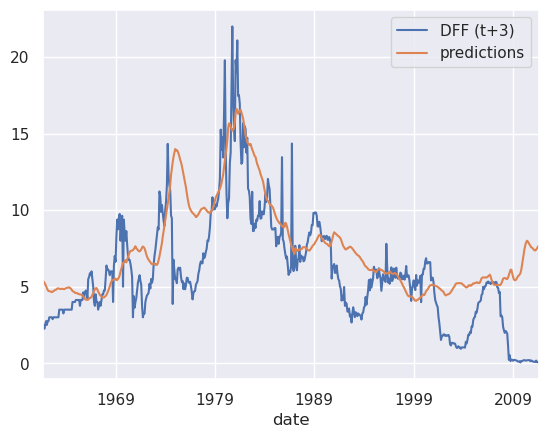

In [15]:
train_with_preds.plot(y = ['DFF (t+3)', 'predictions'], use_index = True)

<Axes: xlabel='date'>

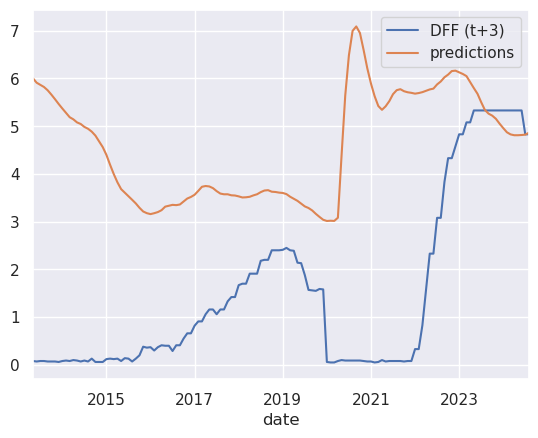

In [16]:
test_with_preds.plot(y = ['DFF (t+3)', 'predictions'], use_index = True)